In [1]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from collections import Counter
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.text import BLEUScore
import spacy
from typing import List

# Load Train data

In [4]:
import sentencepiece as spm
# import os

# # 1. Đường dẫn file gốc
# file_en_path = "/kaggle/input/medicaldataset-vlsp/MedicalDataset_VLSP/train.en.txt"
# file_vi_path = "/kaggle/input/medicaldataset-vlsp/MedicalDataset_VLSP/train.vi.txt"

# # Kiểm tra xem file có thật sự tồn tại và có dữ liệu không
# if os.path.getsize(file_en_path) == 0 or os.path.getsize(file_vi_path) == 0:
#     raise ValueError("Lỗi: File dữ liệu đầu vào bị rỗng hoặc không tồn tại!")

# # 2. Train SentencePiece trực tiếp (Không cần gộp file thủ công)
# # SentencePiece cho phép truyền danh sách file cách nhau bằng dấu phẩy
# input_arg = f"{file_en_path},{file_vi_path}"

# print(f"Đang train SentencePiece trên: {input_arg}")

# spm.SentencePieceTrainer.train(
#     input=input_arg,             # Truyền trực tiếp danh sách file
#     model_prefix="spm_en_vi",
#     vocab_size=16000,
#     model_type="bpe",
    
#     # --- CÁC THAM SỐ FIX LỖI TREO ---
#     character_coverage=0.9995,   # QUAN TRỌNG: Giảm xuống 0.9995 để bỏ qua ký tự rác gây treo
#     input_sentence_size=1000000, # Lấy mẫu 1 triệu câu
#     shuffle_input_sentence=True,
#     max_sentence_length=4096,
#     num_threads=4,               # Kaggle hỗ trợ 4 threads
#     # --------------------------------
    
#     pad_id=0,
#     unk_id=1,
#     bos_id=2,
#     eos_id=3,
    
#     # Tắt check ký tự quá khắt khe để tránh lỗi runtime
#     # hard_vote_limit=False 
# )

# print("Training complete! File spm_en_vi.model đã được tạo.")



In [7]:
# 3. Test thử load model xem ngon chưa
sp = spm.SentencePieceProcessor()
sp.load("spm_en_vi.model")
print("Test encode:", sp.encode_as_pieces("primary Sjögren syndrome"))
print(f"Kích thước Vocab: {sp.get_piece_size()}")

Test encode: ['▁primary', '▁Sj', 'ö', 'gren', '▁syndrome']
Kích thước Vocab: 16000


In [8]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset

# Định nghĩa các ID đặc biệt khớp với lúc train SentencePiece
PAD_ID = 0
UNK_ID = 1
BOS_ID = 2
EOS_ID = 3

class IWSLTDataset(Dataset):
    def __init__(self, src_file, tgt_file):
        self.src_lines = []
        self.tgt_lines = []
        
        print("Đang đọc và lọc dữ liệu...")
        with open(src_file, 'r', encoding='utf-8') as fs, \
             open(tgt_file, 'r', encoding='utf-8') as ft:
            
            # Dùng zip để đọc song song 2 file cùng lúc
            # Nếu 2 file lệch dòng gốc, zip sẽ tự dừng ở file ngắn hơn -> Tránh crash
            for s_line, t_line in zip(fs, ft):
                s_clean = s_line.strip()
                t_clean = t_line.strip()
                
                # Logic quan trọng: Chỉ lấy khi CẢ 2 đều có dữ liệu
                if s_clean and t_clean:
                    self.src_lines.append(s_clean)
                    self.tgt_lines.append(t_clean)
        
        print(f"Hoàn tất load data. Số cặp câu hợp lệ: {len(self.src_lines)}")

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        return self.src_lines[idx], self.tgt_lines[idx]


def collate_batch(batch):
    """
    Hàm này xử lý một batch dữ liệu:
    1. Tokenize text thành list of IDs.
    2. Thêm BOS (Start) và EOS (End) tokens.
    3. Pad (điền số 0) để các câu có độ dài bằng nhau.
    """
    src_batch, tgt_batch = [], []
    
    for src_text, tgt_text in batch:
        # Tokenize và thêm BOS/EOS
        src_ids = [BOS_ID] + sp.encode_as_ids(src_text) + [EOS_ID]
        tgt_ids = [BOS_ID] + sp.encode_as_ids(tgt_text) + [EOS_ID]
        
        src_batch.append(torch.tensor(src_ids, dtype=torch.long))
        tgt_batch.append(torch.tensor(tgt_ids, dtype=torch.long))
    
    # Pad sequence: tạo tensor hình chữ nhật (Batch_Size, Max_Len)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_ID)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_ID)
    
    return src_padded, tgt_padded

# --- CẤU HÌNH VÀ TẠO DATALOADER ---

# Đường dẫn file (sử dụng file bạn đã tạo ra ở cell đầu tiên)
train_src_file = "/kaggle/input/medicaldataset-vlsp/MedicalDataset_VLSP/train.en.txt"
train_tgt_file = "/kaggle/input/medicaldataset-vlsp/MedicalDataset_VLSP/train.vi.txt"

# Tạo Dataset
full_train_dataset = Subset(IWSLTDataset(train_src_file, train_tgt_file),range(50000))

# Tạo DataLoader
BATCH_SIZE = 16 # Bạn có thể giảm xuống 16 nếu bị tràn RAM (OOM)

Đang đọc và lọc dữ liệu...
Hoàn tất load data. Số cặp câu hợp lệ: 500000


In [9]:
# 1. Tính toán kích thước 90% train, 10% validation
val_size = int(len(full_train_dataset) * 0.1)
train_size = len(full_train_dataset) - val_size

# 2. Tách dataset
# Dùng manual_seed để đảm bảo lần nào chạy cũng chia y hệt nhau
train_subset, val_subset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42) 
)

# 3. Tạo DataLoader từ các tập con
train_loader = DataLoader(train_subset,num_workers=2,
                          batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_batch)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE,num_workers=2,   
                        shuffle=False, collate_fn=collate_batch)

print(f"Chia xong: {len(train_subset)} câu train, {len(val_subset)} câu val.")
print(f"-> Sẵn sàng dùng `train_loader` và `val_loader` để huấn luyện.")

Chia xong: 45000 câu train, 5000 câu val.
-> Sẵn sàng dùng `train_loader` và `val_loader` để huấn luyện.


# Xây dựng Kiến trúc Transformer

In [10]:
import copy
# clone helper
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [11]:
def attention(query, key, value, mask= None, dropout= None):
    """
    query, key, value: (batch_size x heads x seq_len x d_k )
    mask: ?
    dropout: nn.Dropout module from whichever module using this function
    returns attention output (batch_size x heads x seq_len x d_k)
      and weights
    """

    d_k = query.size(-1) # get head size
    # score = query x key_transpose/ head_size
    score = torch.matmul(query, key.transpose(-2, -1) / math.sqrt(d_k))

    if mask is not None:
        score = score.masked_fill(mask == 0, float('-inf')) # big negative

    # softmax to probabilities
    score = nn.functional.softmax(score, dim = -1)

    if dropout is not None:
        score = dropout(score)
    output = torch.matmul(score, value) # (seq_len x seq_len) @ (seq_len x d_model), no transpose :)
    return output, score # don't really need score

In [12]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [13]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        self.dim = dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, seq_len, *, device=None, dtype=None):
        if device is None:
            device = self.inv_freq.device
        t = torch.arange(seq_len, device=device, dtype=dtype)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        # Complex numbers for rotation
        emb = torch.cat((freqs, freqs), dim=-1)
        return emb.cos(), emb.sin()

def apply_rotary_pos_emb(q, k, freqs):
    # freqs contains (cos, sin) values
    cos, sin = freqs

    # Reshape cos and sin for broadcasting: (1, 1, seq_len, dim)
    # q, k shape: (batch_size, num_heads, seq_len, dim_per_head)
    cos = cos.unsqueeze(0).unsqueeze(0)
    sin = sin.unsqueeze(0).unsqueeze(0)

    # Apply rotation to query and key using complex number multiplication equivalent
    # [x0, x1, x2, x3, ...] -> [x0*cos - x1*sin, x0*sin + x1*cos, x2*cos - x3*sin, ...]
    q_rot = q * cos - rotate_half(q) * sin
    k_rot = k * cos - rotate_half(k) * sin

    return q_rot, k_rot

def rotate_half(x):
    # Rotates the second half of the embedding dimension by 180 degrees.
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

In [14]:
class MultiHeadedAttention(nn.Module):
  # d_model = embedding dimensions
  def __init__(self, h, d_model, dropout=0.1):
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0
    self.d_k = d_model // h
    self.h = h
    self.linears = get_clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)
    # self.rotary = rotary # Store the RoPE instance

  def forward(self, query, key, value, mask= None):
    """
    q,k,v: batch_size x seq_length x d_model
    mask?
    output: batch_size x seq_length x d_model
    """
    if mask is not None:
      # Same mask applied to all h heads.
      mask = mask.unsqueeze(1)

    nbatches = query.size(0)

    query, key, value = [
        lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for lin, x in zip(self.linears, (query, key, value))
    ]
    # Apply attention on all the projected vectors in batch.
    x, self.attn = attention(
        query, key, value, mask=mask, dropout=self.dropout
    )

    #  "Concat" using a view and apply a final linear.
    x = (
        x.transpose(1, 2)
        .contiguous()
        .view(nbatches, -1, self.h * self.d_k)
    )
    del query
    del key
    del value
    return self.linears[-1](x)

In [15]:
# embedding before encoder
# lut = lookup table, x is the tensor to look up
#
class Embedding(nn.Module):
  def __init__(self, d_model, vocab):
    super(Embedding, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model
  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model) # why???

In [16]:
class LayerNorm(nn.Module):
    # implement layer normalization
    # eps for numerical stability
    def __init__(self, features, eps=1e-6):
      super(LayerNorm, self).__init__()
      self.a_2 = nn.Parameter(torch.ones(features))
      self.b_2 = nn.Parameter(torch.zeros(features))
      self.eps = eps
    def forward(self, x):
      mean = x.mean(-1, keepdim=True)
      std = x.std(-1, keepdim=True)
      return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


In [17]:
class SublayerConnection(nn.Module):
  # residual + norm
  # norm before or after? before!
  """ connect sub layers """
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

In [18]:
class PositionwiseFeedForward(nn.Module):
  # add non-linearities to attention
  # just two linear transformation with an activation (ReLU)
  # we can try using something else like SiLU, but can we justify it?
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    return self.w_2(self.dropout(self.w_1(x).relu()))

In [19]:
class Encoder(nn.Module):
    # nn.Module là lớp cơ sở cho tất cả các mạng neural trong PyTorch
    """multiple stacked layers of EncoderLayer"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = get_clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [20]:
class EncoderLayer(nn.Module):
  """a layer of encoder"""
  """self attention then ffw"""
  # size = d_model
  # x is input?
  def __init__(self, size, self_attn, ffw, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.ffw = ffw
    self.sublayer = get_clones(SublayerConnection(size, dropout), 2)
    self.size = size
  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # q,k,v is the same!
    return self.sublayer[1](x, lambda x: self.ffw(x))


In [21]:
class DecoderLayer(nn.Module):
  # self-explanatory
  # needs mask for self-attention
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = get_clones(SublayerConnection(size, dropout), 3)
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [22]:
# mask helper
def subsequent_mask(size):
    "Mask out future positions"
    return torch.tril(torch.ones(size, size, dtype=torch.bool)).unsqueeze(0)

In [23]:
class Decoder(nn.Module):
  # cũng nhiều lớp decoder xếp chồng lên nhau
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = get_clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [24]:
class EncoderDecoder(nn.Module):
    """
    wrap the things together
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [25]:
class Generator(nn.Module):
  """final linear + softmax step"""
  def __init__(self, d_model, vocab):
      super(Generator, self).__init__()
      self.proj = nn.Linear(d_model, vocab)
  def forward(self, x):
      return nn.functional.log_softmax(self.proj(x), dim=-1)

# Huấn luyện và Đánh giá

In [26]:
class Batch:
    def __init__(self, src, tgt=None, pad=PAD_ID):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    # hide the PADDING too
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

In [27]:
def make_model(src_vocab, tgt_vocab, layers , h, d_model , d_ff , dropout = 0.1):
  # just make a model :)
  c = copy.deepcopy
  # rotary_pe = RotaryPositionalEmbedding(d_model // h)
  attn = MultiHeadedAttention(h, d_model) # Pass rotary_pe to attention
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
    Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), layers),
    Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), layers),
    nn.Sequential(Embedding(d_model, src_vocab),c(position)),
    nn.Sequential(Embedding(d_model, tgt_vocab),c(position)),
    Generator(d_model, tgt_vocab),
  )
  for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
  return model

In [28]:
# used in inference
def beam_search(model, memory, src_mask, start_symbol, end_symbol, max_len=100, beam_size=5, device='cpu'):
    # memory: output of the encoder
    # src_mask: source mask
    # start_symbol: token for <s>
    # end_symbol: token for </s>
    # max_len: maximum length of generated sequence
    # beam_size: number of candidates to keep at each step

    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize with the start symbol
    ys = torch.full((1, 1), start_symbol, dtype=torch.long, device=device)

    # Store (log_probability, sequence_so_far)
    candidates = [(0.0, ys)]

    for _ in range(max_len - 1):
        new_candidates = []
        # Iterate through current best candidates
        for log_prob, current_sequence in candidates:

            # If the sequence already ended, keep it as is
            if current_sequence[0, -1].item() == end_symbol:
                new_candidates.append((log_prob, current_sequence))
                continue

            # Create target mask for the current sequence
            tgt_mask = subsequent_mask(current_sequence.size(-1)).type_as(memory)

            # Decode the next token
            out = model.decode(memory, src_mask, current_sequence, tgt_mask)
            prob = model.generator(out[:, -1]) # Get probabilities for the last token
            log_probs = prob.log_softmax(dim=-1) # Convert to log probabilities

            # Get top 'beam_size' next tokens and their log probabilities
            top_k_log_probs, top_k_indices = log_probs.topk(beam_size)

            for i in range(beam_size):
                next_token_log_prob = top_k_log_probs[0, i].item()
                next_token = top_k_indices[0, i].item()

                # Extend the current sequence with the new token
                extended_sequence = torch.cat(
                    [current_sequence, torch.full((1, 1), next_token, dtype=torch.long, device=device)], dim=1
                )
                new_candidates.append((log_prob + next_token_log_prob, extended_sequence))

        # Sort all new candidates by their log probability and select the top 'beam_size'
        candidates = sorted(new_candidates, key=lambda x: x[0], reverse=True)[:beam_size]

        # If all best candidates have ended, we can stop early (optional optimization)
        if all(cand[1][0, -1].item() == end_symbol for cand in candidates):
            break

    # Return the best sequence (highest log probability)
    return candidates[0][1].cpu().squeeze().tolist()


In [29]:
def rate(step, d_model, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        d_model ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [30]:
#loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx = 0, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [31]:
import math

def evaluate_loss(model, val_dataloader, criterion, device, pad_idx = PAD_ID):
    """
    Chạy model trên tập Val để tính Loss và Perplexity
    """
    model.eval() # Chuyển sang chế độ đánh giá (tắt Dropout)
    total_loss = 0
    
    with torch.no_grad(): # Tắt tính toán gradient để tiết kiệm RAM
        for batch_data in val_dataloader:
            src, tgt = batch_data[0].to(device), batch_data[1].to(device)
            batch = Batch(src, tgt, pad=pad_idx)
            
            # Forward pass
            out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
            out = model.generator(out)
            
            # Tính Loss
            loss = criterion(out.contiguous().view(-1, out.size(-1)), 
                             batch.tgt_y.contiguous().view(-1))
            total_loss += loss.item()
            
    avg_loss = total_loss / len(val_dataloader)
    
    # Tính Perplexity (PPL) = exp(Loss)
    # PPL càng thấp càng tốt
    try:
        ppl = math.exp(avg_loss)
    except OverflowError:
        ppl = float('inf')
        
    model.train() # Quan trọng: Chuyển lại về chế độ train cho epoch sau
    return avg_loss, ppl

In [32]:
import torch

def translate_sentence(sentence, model, sp_model, device, max_len=100):
    model.eval() # Chuyển sang chế độ đánh giá
    
    # 1. Tokenize câu đầu vào
    # Thêm BOS và EOS giống hệt lúc train
    tokens = [BOS_ID] + sp_model.encode_as_ids(sentence) + [EOS_ID]
    src = torch.tensor(tokens).long().unsqueeze(0).to(device) # (1, seq_len)
    
    # 2. Tạo mask
    src_mask = (src != PAD_ID).unsqueeze(-2)
    
    # 3. Encoder
    with torch.no_grad():
        memory = model.encode(src, src_mask)
        
    # 4. Beam Search (Hàm này bạn đã có trong code gốc)
    # Lưu ý: Cần đảm bảo hàm beam_search đã được định nghĩa
    output_ids = beam_search(model, memory, src_mask, BOS_ID, EOS_ID, max_len, beam_size=3, device=device)
    
    # 5. Decode
    if EOS_ID in output_ids:
        output_ids = output_ids[:output_ids.index(EOS_ID)]
        
    translation = sp_model.decode(output_ids)
    
    model.train() # Chuyển lại về mode train
    return translation

In [33]:
# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

D_MODEL = 128
VOCAB_SIZE = sp.get_piece_size() 
D_FF = 1024
LAYERS=4
H=4
# Quan trọng: LabelSmoothingLoss cần input đúng kích thước vocab
criterion = LabelSmoothingLoss(classes=VOCAB_SIZE, padding_idx=PAD_ID, smoothing=0.1)

# Khởi tạo mô hình (đảm bảo hàm make_model đã được sửa như mục 3)
model = make_model(src_vocab=VOCAB_SIZE, tgt_vocab=VOCAB_SIZE, 
                   layers=LAYERS, h=H, d_model=D_MODEL, d_ff=D_FF, dropout=0.1)

model.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters.")

Using device: cuda
Model created with 9064576 parameters.


In [ ]:
def train_with_validation_and_checkpointing(
    model, train_dataloader, val_dataloader, criterion, optimizer, lr_scheduler, 
    device, pad_idx, sp_model, num_epochs, sample_sentence,
    start_epoch=0, best_val_loss=float('inf')
):
    model.train()
    scaler = torch.amp.GradScaler("cuda")
    print(f"{'='*10} BẮT ĐẦU TRAINING VỚI  {'='*10}")

    # Khởi tạo history để lưu kết quả
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_ppl": []
    }
    print(f"{'='*10} BẮT ĐẦU TRAINING TỪ EPOCH {start_epoch + 1} {'='*10}")
    for epoch in range(start_epoch, num_epochs):
        print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")
        
        # 1. TRAINING LOOP
        model.train()
        train_loss = 0
        pbar = tqdm(train_dataloader, desc="Training")
        
        for i, batch_data in enumerate(pbar):
            src, tgt = batch_data[0].to(device), batch_data[1].to(device)
            # Skip câu quá dài
            if src.size(1) > 150 or tgt.size(1) > 150: continue
            
            batch = Batch(src, tgt, pad=pad_idx)
            with torch.amp.autocast(device_type="cuda"):
            # with autocast():
                out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
                out = model.generator(out)
                loss = criterion(out.contiguous().view(-1, out.size(-1)), batch.tgt_y.contiguous().view(-1))

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"loss": loss.item(), "lr": optimizer.param_groups[0]["lr"]})
            
        avg_train_loss = train_loss / len(train_dataloader)
        
        # 2. VALIDATION LOOP (Sau khi xong 1 epoch train)
        print("Đang chạy validate...")
        avg_val_loss, val_ppl = evaluate_loss(model, val_dataloader, criterion, device, pad_idx)
        
        print(f" KẾT QUẢ EPOCH {epoch+1}:")
        print(f"   - Train Loss: {avg_train_loss:.4f}")
        print(f"   - Val Loss:   {avg_val_loss:.4f} (Perplexity: {val_ppl:.2f})")
        
        # 1. Lưu checkpoint của epoch cuối cùng (để phòng khi bị crash giữa chừng)
        torch.save({
            'epoch': epoch + 1, # Lưu epoch kế tiếp sẽ chạy
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'best_val_loss': best_val_loss,
        }, "last_vlsp_checkpoint.pth")
        
        # 2. Lưu checkpoint tốt nhất (dựa trên val_loss)
        if avg_val_loss < best_val_loss:
            print(f" Loss giảm ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Lưu best checkpoint!")
            best_val_loss = avg_val_loss
            # Gói tất cả vào một dictionary
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'best_val_loss': best_val_loss,
            }, "best_vlsp_checkpoint.pth")
        else:
            print(f" Loss không giảm (Best: {best_val_loss:.4f}). Không cập nhật best checkpoint.")
            
        # Lưu kết quả vào history
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_ppl"].append(val_ppl)
        # 4. Dịch thử
        if sp_model:
            try:
                pred = translate_sentence(sample_sentence, model, sp_model, device)
                print(f"   - Dịch thử: {pred}")
            except: pass
            
    print(f"\nTraining hoàn tất! Best Val Loss: {best_val_loss:.4f}")
    return history

In [ ]:
def load_checkpoint(model, optimizer, scheduler, filename="last_checkpoint.pth"):
    start_epoch = 0
    best_val_loss = float('inf')
    
    if os.path.exists(filename):
        print(f"--- Đang tải checkpoint từ: {filename} ---")
        checkpoint = torch.load(filename, map_location=device)
        
        # Khôi phục trạng thái
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Lấy thông tin epoch và loss để train tiếp
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        
        print(f" Khôi phục thành công! Sẵn sàng train tiếp từ Epoch {start_epoch + 1}.")
        print(f"   - Best Val Loss đã ghi nhận: {best_val_loss:.4f}")
        print(f"   - Learning Rate hiện tại: {optimizer.param_groups[0]['lr']:.6f}")
    else:
        print("--- Không tìm thấy checkpoint. Bắt đầu training từ đầu. ---")
        
    return start_epoch, best_val_loss


In [36]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """
    Vẽ đồ thị Train Loss, Val Loss, và Val Perplexity.
    """
    # Lấy dữ liệu từ history
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    val_ppl = history['val_ppl']
    epochs = range(1, len(train_loss) + 1)
    
    # Tạo figure với 2 subplot
    plt.figure(figsize=(14, 5))
    
    # --- Biểu đồ 1: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # --- Biểu đồ 2: Perplexity ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_ppl, 'go-', label='Validation Perplexity')
    plt.title('Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# EXE

========== BẮT ĐẦU TRAINING VỚI  ==========
========== BẮT ĐẦU TRAINING TỪ EPOCH 1 ==========

--- Epoch 1/25 ---


Training: 100%|██████████| 2813/2813 [02:43<00:00, 17.19it/s, loss=2.81, lr=0.000959]

Đang chạy validate...


📌 KẾT QUẢ EPOCH 1:
   - Train Loss: 2.9181
   - Val Loss:   2.2554 (Perplexity: 9.54)
✅ Loss giảm (inf -> 2.2554). Lưu best checkpoint!
   - Dịch thử: Một số yếu tố liên quan đến kiến thức, thực hành của người bệnh COVID-19 tại các khoa học Y học, tỉnh Nam Định

--- Epoch 2/25 ---


Training: 100%|██████████| 2813/2813 [02:40<00:00, 17.50it/s, loss=2.67, lr=0.00119]

Đang chạy validate...


📌 KẾT QUẢ EPOCH 2:
   - Train Loss: 2.1153
   - Val Loss:   1.9361 (Perplexity: 6.93)
✅ Loss giảm (2.2554 -> 1.9361). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thái độ về dịch vụ y tế của nhân viên y tế và một số yếu tố ảnh hưởng đến các yếu tố ảnh hưởng đến các yếu tố ảnh hưởng của nhân viên y tế tại Hà Nội, Hà Nội

--- Epoch 3/25 ---


Training: 100%|██████████| 2813/2813 [02:40<00:00, 17.52it/s, loss=2.32, lr=0.000974] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 3:
   - Train Loss: 1.8739
   - Val Loss:   1.7865 (Perplexity: 5.97)
✅ Loss giảm (1.9361 -> 1.7865). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế của nhân viên y tế và các yếu tố ảnh hưởng đến chất lượng cuộc sống của nhân viên y tế tại huyện Phú Thọ

--- Epoch 4/25 ---


Training: 100%|██████████| 2813/2813 [02:40<00:00, 17.48it/s, loss=2.18, lr=0.000844] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 4:
   - Train Loss: 1.7496
   - Val Loss:   1.7033 (Perplexity: 5.49)
✅ Loss giảm (1.7865 -> 1.7033). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành sử dụng dịch vụ khám chữa bệnh của nhân viên y tế công tác và các yếu tố ảnh hưởng đến sự ảnh hưởng đến sự ảnh hưởng của cán bộ y tế huyện Lào Cai, Sơn La

--- Epoch 5/25 ---


Training: 100%|██████████| 2813/2813 [02:40<00:00, 17.51it/s, loss=1.61, lr=0.000755] 


Đang chạy validate...
📌 KẾT QUẢ EPOCH 5:
   - Train Loss: 1.6693
   - Val Loss:   1.6445 (Perplexity: 5.18)
✅ Loss giảm (1.7033 -> 1.6445). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế ở nhân viên y tế và một số yếu tố ảnh hưởng đến sức khoẻ của nhân viên y tế huyện Lào Cai

--- Epoch 6/25 ---


Training: 100%|██████████| 2813/2813 [02:40<00:00, 17.50it/s, loss=2.83, lr=0.000689] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 6:
   - Train Loss: 1.6074
   - Val Loss:   1.6041 (Perplexity: 4.97)
✅ Loss giảm (1.6445 -> 1.6041). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế của nhân viên y tế trong việc bảo hiểm y tế và các yếu tố ảnh hưởng đến sức khoẻ của nhân viên y tế.

--- Epoch 7/25 ---


Training: 100%|██████████| 2813/2813 [02:38<00:00, 17.79it/s, loss=2.21, lr=0.000638] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 7:
   - Train Loss: 1.5606
   - Val Loss:   1.5749 (Perplexity: 4.83)
✅ Loss giảm (1.6041 -> 1.5749). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế của nhân viên y tế trong việc bảo hiểm y tế và một số yếu tố ảnh hưởng của nhân viên y tế, năm 2021

--- Epoch 8/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.86it/s, loss=1.8, lr=0.000597]  

Đang chạy validate...


📌 KẾT QUẢ EPOCH 8:
   - Train Loss: 1.5316
   - Val Loss:   1.5494 (Perplexity: 4.71)
✅ Loss giảm (1.5749 -> 1.5494). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế của nhân viên y tế về bảo hiểm y tế và tìm hiểu một số yếu tố ảnh hưởng đến sức khoẻ của nhân viên y tế, tỉnh LOA

--- Epoch 9/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.85it/s, loss=2.43, lr=0.000563] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 9:
   - Train Loss: 1.4943
   - Val Loss:   1.5297 (Perplexity: 4.62)
✅ Loss giảm (1.5494 -> 1.5297). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế của nhân viên y tế trong việc bảo hiểm y tế và các yếu tố ảnh hưởng đến hoạt động của cán bộ y tế, tỉnh Lào Cai

--- Epoch 10/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.83it/s, loss=1.91, lr=0.000534] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 10:
   - Train Loss: 1.4669
   - Val Loss:   1.5157 (Perplexity: 4.55)
✅ Loss giảm (1.5297 -> 1.5157). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công nghiệp của nhân viên y tế và các yếu tố ảnh hưởng đến nhu cầu, năm 2020

--- Epoch 11/25 ---


Training: 100%|██████████| 2813/2813 [02:38<00:00, 17.79it/s, loss=1.89, lr=0.000509] 


Đang chạy validate...
📌 KẾT QUẢ EPOCH 11:
   - Train Loss: 1.4533
   - Val Loss:   1.4989 (Perplexity: 4.48)
✅ Loss giảm (1.5157 -> 1.4989). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và các yếu tố ảnh hưởng đến sức khoẻ, năm 2021

--- Epoch 12/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.89it/s, loss=1.82, lr=0.000487] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 12:
   - Train Loss: 1.4301
   - Val Loss:   1.4886 (Perplexity: 4.43)
✅ Loss giảm (1.4989 -> 1.4886). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và một số yếu tố ảnh hưởng đến sức khoẻ, xác định một số yếu tố liên quan

--- Epoch 13/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.89it/s, loss=1.79, lr=0.000468] 


Đang chạy validate...
📌 KẾT QUẢ EPOCH 13:
   - Train Loss: 1.4076
   - Val Loss:   1.4790 (Perplexity: 4.39)
✅ Loss giảm (1.4886 -> 1.4790). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và các yếu tố ảnh hưởng đến chức năng xã hội.

--- Epoch 14/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.90it/s, loss=1.69, lr=0.000451] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 14:
   - Train Loss: 1.3958
   - Val Loss:   1.4727 (Perplexity: 4.36)
✅ Loss giảm (1.4790 -> 1.4727). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và các yếu tố ảnh hưởng đến sức khoẻ tại xã hội, tỉnh Lào Cai

--- Epoch 15/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.90it/s, loss=1.03, lr=0.000436] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 15:
   - Train Loss: 1.3848
   - Val Loss:   1.4645 (Perplexity: 4.33)
✅ Loss giảm (1.4727 -> 1.4645). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và một số yếu tố ảnh hưởng đến sức khoẻ, thành phố Lào Cai

--- Epoch 16/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.91it/s, loss=1.38, lr=0.000422] 


Đang chạy validate...
📌 KẾT QUẢ EPOCH 16:
   - Train Loss: 1.3639
   - Val Loss:   1.4606 (Perplexity: 4.31)
✅ Loss giảm (1.4645 -> 1.4606). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và một số yếu tố ảnh hưởng đến nhu cầu sử dụng dịch vụ y tế, Lào Cai

--- Epoch 17/25 ---


Training: 100%|██████████| 2813/2813 [02:36<00:00, 17.92it/s, loss=1.03, lr=0.000409] 


Đang chạy validate...
📌 KẾT QUẢ EPOCH 17:
   - Train Loss: 1.3536
   - Val Loss:   1.4513 (Perplexity: 4.27)
✅ Loss giảm (1.4606 -> 1.4513). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và một số yếu tố ảnh hưởng tại xã hội, Lào Cai

--- Epoch 18/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.89it/s, loss=1.66, lr=0.000398] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 18:
   - Train Loss: 1.3453
   - Val Loss:   1.4503 (Perplexity: 4.26)
✅ Loss giảm (1.4513 -> 1.4503). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng đồng về bảo hiểm y tế và một số yếu tố ảnh hưởng đến nhu cầu và phân lập được.

--- Epoch 19/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.87it/s, loss=1.13, lr=0.000387] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 19:
   - Train Loss: 1.3287
   - Val Loss:   1.4451 (Perplexity: 4.24)
✅ Loss giảm (1.4503 -> 1.4451). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và một số yếu tố ảnh hưởng

--- Epoch 20/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.90it/s, loss=1.72, lr=0.000377] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 20:
   - Train Loss: 1.3258
   - Val Loss:   1.4452 (Perplexity: 4.24)
⚠️ Loss không giảm (Best: 1.4451). Không cập nhật best checkpoint.
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và các yếu tố ảnh hưởng đến sức khoẻ tại xã hội, Lào Cai

--- Epoch 21/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.86it/s, loss=1.36, lr=0.000368] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 21:
   - Train Loss: 1.3173
   - Val Loss:   1.4364 (Perplexity: 4.21)
✅ Loss giảm (1.4451 -> 1.4364). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và các yếu tố ảnh hưởng đến hoạt động, địa bàn thành phố Lào Cai

--- Epoch 22/25 ---


Training: 100%|██████████| 2813/2813 [02:37<00:00, 17.87it/s, loss=1.81, lr=0.00036]  

Đang chạy validate...


📌 KẾT QUẢ EPOCH 22:
   - Train Loss: 1.3094
   - Val Loss:   1.4338 (Perplexity: 4.19)
✅ Loss giảm (1.4364 -> 1.4338). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và một số yếu tố ảnh hưởng đến nhu cầu sử dụng dịch vụ, Lào Cai

--- Epoch 23/25 ---


Training: 100%|██████████| 2813/2813 [02:40<00:00, 17.56it/s, loss=1.43, lr=0.000352] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 23:
   - Train Loss: 1.3047
   - Val Loss:   1.4322 (Perplexity: 4.19)
✅ Loss giảm (1.4338 -> 1.4322). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và một số yếu tố ảnh hưởng đến thực hành, Lào Cai

--- Epoch 24/25 ---


Training: 100%|██████████| 2813/2813 [02:41<00:00, 17.37it/s, loss=1.15, lr=0.000344] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 24:
   - Train Loss: 1.2920
   - Val Loss:   1.4297 (Perplexity: 4.18)
✅ Loss giảm (1.4322 -> 1.4297). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và một số yếu tố ảnh hưởng đến thực hành, Lào Cai

--- Epoch 25/25 ---


Training: 100%|██████████| 2813/2813 [02:39<00:00, 17.59it/s, loss=1.92, lr=0.000337] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 25:
   - Train Loss: 1.2826
   - Val Loss:   1.4247 (Perplexity: 4.16)
✅ Loss giảm (1.4297 -> 1.4247). Lưu best checkpoint!
   - Dịch thử: Kiến thức, thực hành về sử dụng dịch vụ y tế công cộng của nhân viên y tế và các yếu tố ảnh hưởng đến nhu cầu và một số yếu tố ảnh hưởng.

Training hoàn tất! Best Val Loss: 1.4247
Training hoàn tất. Đang vẽ đồ thị...


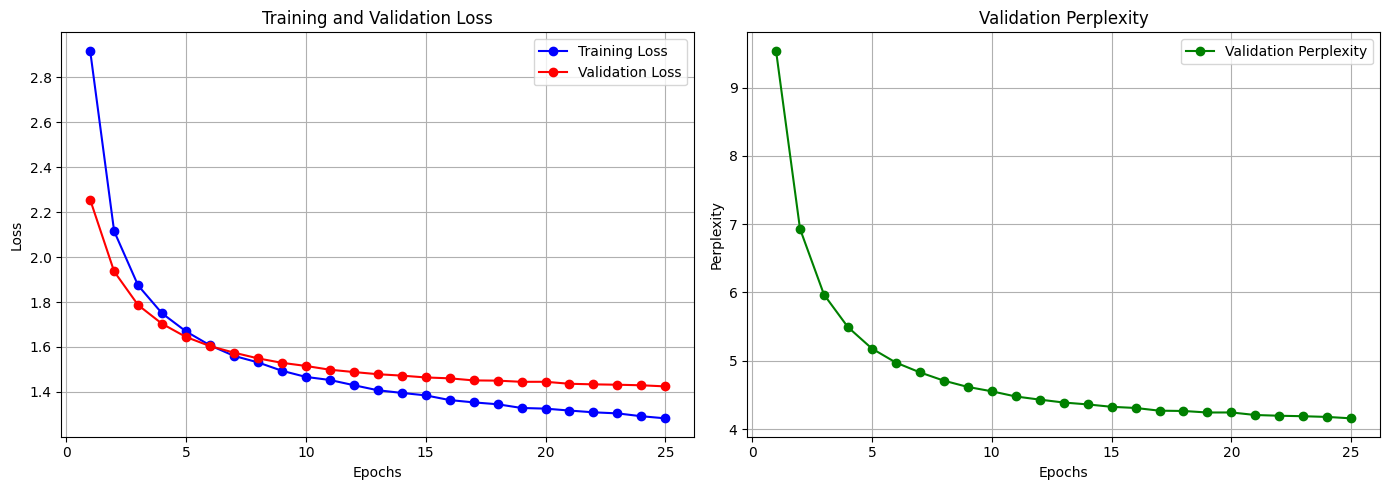

In [37]:
from tqdm import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)
lr_scheduler = LambdaLR(optimizer=optimizer,
    lr_lambda=lambda step: rate(step, d_model=D_MODEL, factor=1, warmup=4000))

# # --- 2. LOAD CHECKPOINT (NẾU CÓ) ---
# # Hàm này sẽ tự động điền trạng thái đã lưu vào các object ở trên
# start_epoch, best_val_loss = load_checkpoint(model, optimizer, lr_scheduler,
#                                              '/kaggle/input/best/pytorch/default/1/best_checkpoint.pth')
# Train lại từ đầu hoặc train tiếp 
try:
    history = train_with_validation_and_checkpointing(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        criterion=criterion,
        optimizer=optimizer,         # Truyền optimizer đã được load state
        lr_scheduler=lr_scheduler,   # Truyền scheduler đã được load state
        device=device,
        pad_idx=PAD_ID,
        sp_model=sp,
        num_epochs=25,               # Ví dụ muốn train tổng cộng 20 epochs
        sample_sentence="Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao",
        # start_epoch=start_epoch,     # Bắt đầu từ epoch đã load
        # best_val_loss=best_val_loss  # Dùng best_loss đã load để so sánh
    )
except KeyboardInterrupt:
    print("Đã dừng training thủ công.")
finally:
    # 2. Sau khi chạy xong (dù thành công hay thất bại), hãy kiểm tra xem 'history' có giá trị hợp lệ không
    if history is not None:
        print("Training hoàn tất. Đang vẽ đồ thị...")
        plot_metrics(history)
    else:
        print("Không có dữ liệu history để vẽ đồ thị do training không thành công.")

# Test

In [39]:
def translate_batch_greedy(src_batch, src_mask, model, max_len=100):
    """
    Dịch một batch câu bằng phương pháp Greedy Search.
    Rất nhanh nhưng chất lượng có thể kém hơn Beam Search một chút.
    """
    batch_size = src_batch.size(0)
    device = src_batch.device
    
    # 1. Chạy Encoder MỘT LẦN cho cả batch
    with torch.no_grad():
        memory = model.encode(src_batch, src_mask)

    # 2. Khởi tạo decoder input với token BOS cho tất cả các câu trong batch
    ys = torch.full((batch_size, 1), BOS_ID, dtype=torch.long, device=device)

    # 3. Vòng lặp giải mã Greedy
    for _ in range(max_len - 1):
        with torch.no_grad():
            # Chạy decoder
            tgt_mask = subsequent_mask(ys.size(1)).type_as(src_mask.data)
            out = model.decode(memory, src_mask, ys, tgt_mask)
            
            # Lấy token cuối cùng và chạy qua generator
            prob = model.generator(out[:, -1])
            
            # Lấy token có xác suất cao nhất (Greedy)
            _, next_word = torch.max(prob, dim=1)
            
            # Nối token mới vào chuỗi kết quả
            ys = torch.cat([ys, next_word.unsqueeze(1)], dim=1)
            
    return ys

def calculate_bleu_fast(model, dataloader, sp_model, device):
    """Tính BLEU score bằng phương pháp dịch theo lô."""
    print("Bắt đầu tính BLEU score (phiên bản nhanh)...")
    
    bleu = BLEUScore(n_gram=4)
    model.eval()
    
    all_preds = []
    all_refs = []

    for batch in tqdm(dataloader, desc="Dịch theo lô"):
        src, tgt = batch[0].to(device), batch[1].to(device)
        
        # Tạo source mask
        src_mask = (src != PAD_ID).unsqueeze(-2)
        
        # Dịch cả batch bằng Greedy Search
        pred_ids_batch = translate_batch_greedy(src, src_mask, model)
        
        # Decode từ ID sang text và lưu kết quả
        for i in range(pred_ids_batch.size(0)):
            # Lấy câu gốc (reference)
            ref_ids = tgt[i, 1:] # Bỏ BOS
            ref_text = sp_model.decode([id for id in ref_ids.tolist() if id != PAD_ID and id != EOS_ID])
            all_refs.append([ref_text])
            
            # Lấy câu dịch (prediction)
            pred_ids = pred_ids_batch[i, 1:] # Bỏ BOS
            pred_text = sp_model.decode([id for id in pred_ids.tolist() if id != PAD_ID and id != EOS_ID])
            all_preds.append(pred_text)
            
    # Tính điểm BLEU cuối cùng
    score = bleu(all_preds, all_refs)
    
    print("\n" + "="*30)
    print(f"KẾT QUẢ BLEU SCORE (Nhanh): {score.item():.4f}")
    print("="*30)
    
    return score.item(), all_preds, all_refs

In [42]:
# 1. Đường dẫn file Test (kiểm tra lại trong folder input của bạn xem tên chính xác là gì)
# Thường là tst2012 hoặc tst2013
test_src_file = "/kaggle/input/medicaldataset-vlsp/MedicalDataset_VLSP/public_test.en.txt"
test_tgt_file = "/kaggle/input/medicaldataset-vlsp/MedicalDataset_VLSP/public_test.vi.txt"

# 2. Tạo Dataset cho tập Test
if os.path.exists(test_src_file):
    print("Đang tạo Test Dataset...")
    test_loader_for_bleu = DataLoader(
        Subset(IWSLTDataset(test_src_file, test_tgt_file), range(256)), 
        batch_size= 8,
        shuffle=False, # Không shuffle khi test
        collate_fn=collate_batch
    )
    # 3. Tính BLEU trên tập Test 
    print("Đang chấm điểm trên tập Test 256 câu" )
    score, preds, refs = calculate_bleu_fast(
        model=model,
        dataloader=test_loader_for_bleu,
        sp_model=sp,
        device=device
    )
else:
    print("Không tìm thấy file Test. Bạn hãy kiểm tra lại đường dẫn trong Input.")

Đang tạo Test Dataset...
Đang đọc và lọc dữ liệu...
Hoàn tất load data. Số cặp câu hợp lệ: 3000
Đang chấm điểm trên tập Test 256 câu
Bắt đầu tính BLEU score (phiên bản nhanh)...


Dịch theo lô: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]



KẾT QUẢ BLEU SCORE (Nhanh): 0.2456


In [ ]:
# import os

# # Nén toàn bộ file trong working thành output.zip
# os.system("zip -r output.zip .")

# from IPython.display import FileLink
# print("Bấm vào đây để tải trọn bộ (ZIP):")
# FileLink(r'output.zip')

In [ ]:
# os.remove("best_model_iwslt.pth")
